In [1]:
# using CuArrays
using AutoGrad
using Deeplearning
using Statistics
using StatsBase
using Plots
import CSV

┌ Info: Recompiling stale cache file /Users/aliceylan/.julia/compiled/v1.1/Deeplearning/gtjFf.ji for Deeplearning [0d5bc7a0-39dd-11e9-2aab-59c8d4b467de]
└ @ Base loading.jl:1184


In [2]:
batch = 100
learning_rate = 10e-4
sample_int = div(42000, batch)-1

419

In [3]:
train = CSV.read("datasets/digit-recognizer/train.csv")
xtrain = []
ytrain = []

for i in 1:size(train)[1]
    max = maximum(train[i,2:end])+0.1
    normalized = reshape(train[i, 2:end]./(max), (28,28,1,1))
    push!(xtrain, normalized)
    push!(ytrain, train[i,1]+1)
end

println("Ready...")

Ready...


In [4]:
test = CSV.read("datasets/digit-recognizer/test.csv")
xtest = []
ytest = [nothing for i in 1:size(test)[1]]
for i in 1:size(test)[1]
    max = maximum(test[i,2:end])+0.1
    normalized = reshape(test[i, 1:end]./(max), (28,28,1,1))
    push!(xtest, normalized)
end

println("Ready...")

Ready...


In [5]:
mnist_train = Deeplearning.minibatch(xtrain, ytrain, batch, shuffle=true)

Deeplearning.Data{Tuple{Array{Any,1},Array{Any,1}}}(Any[[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0] [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0] … [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0] [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]], Any[2 1 … 7 10], 100, 42000, false, 41901, 1:42000, true, (42000,), (42000,), Array{Any,1}, Array{Any,1})

In [6]:
mnist_test = Deeplearning.minibatch(xtest, ytest, batch, shuffle=true)

Deeplearning.Data{Tuple{Array{Any,1},Array{Nothing,1}}}(Any[[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0] [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0] … [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0] [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]], Nothing[nothing nothing … nothing nothing], 100, 28000, false, 27901, 1:28000, true, (28000,), (28000,), Array{Any,1}, Array{Nothing,1})

In [7]:
conv1 = Deeplearning.ConvolutionLayer((3,3,6), (2,2), (1,1), xavier, sigmoid)((28,28,1,1))
conv2 = Deeplearning.ConvolutionLayer((3,3,16), (2,2), (1,1), xavier, sigmoid)(conv1.telemetry.o)
dense1 = Deeplearning.FullyConnectedLayer(120, xavier, sigmoid)(conv2.telemetry.o)
dense2 = Deeplearning.FullyConnectedLayer(84, xavier, sigmoid)(dense1.telemetry.o)
dense3 = Deeplearning.FullyConnectedLayer(10, xavier, x->x)(dense2.telemetry.o)
layers=[dense3,dense2,dense1,conv2,conv1]
println("Loaded")

Loaded


In [8]:
function f(x)
    x = cat(x...,dims=4)
    x = conv1(x,s=(2,2))    
    x = conv2(x,s=(2,2))    
    x = dense1(x)
    x = dense2(x)
    x = dense3(x)
    x = softmax(x)
end

f (generic function with 1 method)

In [9]:
lenet5v2 = Deeplearning.Network(layers, f, loss=nll)

Deeplearning.Network(Any[FullyConnectedLayer(LayerTelemetry((10, 84), (10, 1, 1), (10, 1, 1)), P(Array{Float64,2}(10,84)), P(Array{Float64,2}(10,1)), ##5#6()), FullyConnectedLayer(LayerTelemetry((84, 120), (84, 1, 1), (84, 1, 1)), P(Array{Float64,2}(84,120)), P(Array{Float64,2}(84,1)), sigmoid), FullyConnectedLayer(LayerTelemetry((120, 576), (120, 1, 1), (120, 1, 1)), P(Array{Float64,2}(120,576)), P(Array{Float64,2}(120,1)), sigmoid), ConvolutionLayer(LayerTelemetry((3, 3, 6, 16), (1, 1, 16, 1), (6, 6, 16, 1)), P(Array{Float64,4}(3,3,6,16)), P(Array{Float64,4}(1,1,16,1)), sigmoid), ConvolutionLayer(LayerTelemetry((3, 3, 1, 6), (1, 1, 6, 1), (13, 13, 6, 1)), P(Array{Float64,4}(3,3,1,6)), P(Array{Float64,4}(1,1,6,1)), sigmoid)], f, Deeplearning.nll)

In [16]:
acc_train_plot = []
acc_test_plot = []
loss_train_plot = []
loss_test_plot = []

0-element Array{Any,1}

In [25]:
for (iteration, data) in enumerate(Deeplearning.progress(repeat(mnist_train, 1)))
    batch_x, batch_y = data

    dv = @diff lenet5v2(batch_x, batch_y)

    dparams = @parameters dv

    for pidx in 1:length(dparams[1:end-1])
        dw = grad(dv, dparams[pidx])
        dw .-=learning_rate*dw
    end
    
    if(iteration%sample_int==1)
#         loss_train, loss_test = lenet5v2(mnist_train), lenet5v2(mnist_test)
#         acc_train, acc_test = acc(lenet5v2, mnist_train), acc(lenet5v2, mnist_test)
        loss_train = lenet5v2(mnist_train)
        push!(loss_train_plot, loss_train)
        
        acc_train = acc(lenet5v2, mnist_train)
        push!(acc_train_plot, acc_train)
    end
    
end

100.00%┣████████████████████████████████████████▉┫ 420/420 [02:51/02:51, 2.46i/s]


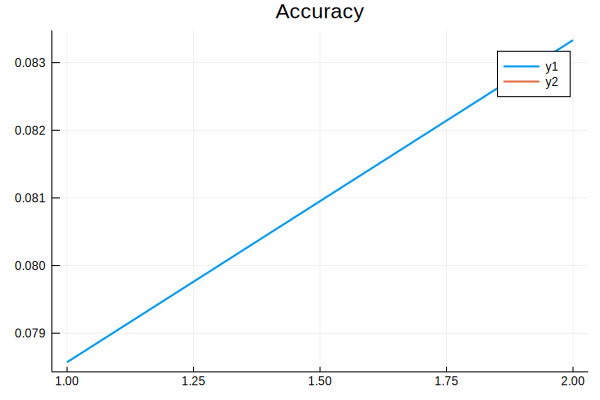

In [26]:
plot([acc_train_plot, acc_test_plot], linewidth=2, title="Accuracy")

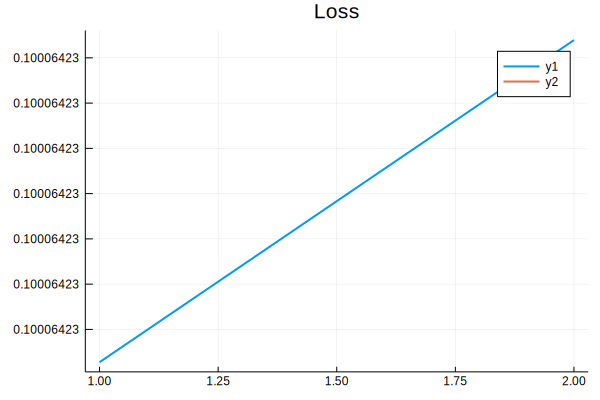

In [27]:
plot([loss_train_plot, loss_test_plot], linewidth=2, title="Loss")